<div dir='rtl'>
<h2> K-means vs GMM (۳۰ نمره)</h2> 


---


در این تمرین قصد داریم دو روش 
kmeans 
و 
GMM
را بدون استفاده از کتابخانه‌های آماده پیاده‌سازی کنیم. 

برای پیاده‌سازی GMM
می‌توانید از تابع نرمال چند متغیره که در 
<code> scipy </code>
است، استفاده کنید.

</div>

<div dir='rtl'>

برای پیاده‌سازی الگوریتم 
K-means
کار را تا جایی ادامه دهید که مرکز خوشه‌ها تغییر نکند.

در پیاده‌سازی الگوریتم GMM
هم تا جایی پیش‌بروید که تفاوت درست‌نمایی در دو دور متوالی کمتر از ۰.۱ باشد.

</div>

<div dir='rtl'>
<h4> الف (۲۰ نمره)</h4>

با استفاده از تابع زیر دیتاست را ایجاد کنید. سپس برای
K=2
دو الگوریتم را روی دیتاست اجرا کنید. 

کیفیت روش‌های پیاده‌سازی شده را با استفاده از دو معیار 
<code> purity </code>
و 
<code> rand-index </code>
با یکدیگر مقایسه کنید.


---


در روش K-means
بهتر است اجرا چند بار انجام شود و بهترین نتیجه گزارش شود.
</div>

In [145]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

<div dir='rtl'>
ابتدا داده‌های ایجاد شده را plot می‌کنیم.
</div>

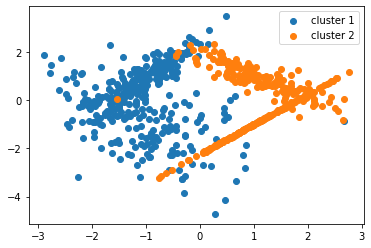

In [146]:
import matplotlib.pyplot as plt
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

In [147]:
import numpy as np
import random

class Kmeans():
    def __init__(self, x, k):
        self.x = x
        self.k = k
        self.centers = np.zeros((k, self.x.shape[1]))
    
    def init_centers(self):
        self.centers[0] = self.x[random.randint(0, self.x.shape[0])]
        for i in range(1, self.k):
            min_dists = dist(self.x, self.centers[: i]).min(axis = 1)
            self.centers[i] = random.choices(self.x, weights = min_dists)[0]
            
            
    def cluster(self, iteration = 100):
        clustered = np.zeros(self.x.shape[0])
        for i in range(iteration):
            pre_centers = np.copy(self.centers)
            clustered = dist(self.x, self.centers).argmin(axis = 1)
            for k in range(self.k):
                if len(self.x[clustered == k] ) > 0:
                    self.centers[k] = np.mean(self.x[clustered == k], axis = 0)
            if (pre_centers == self.centers).all():
                break
        return clustered

    
def dist(x, y):
    x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), y.shape[0], axis = 1)
    y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), x.shape[0], axis = 0)
    return x_norm + y_norm - 2 * np.matmul(x, y.T)

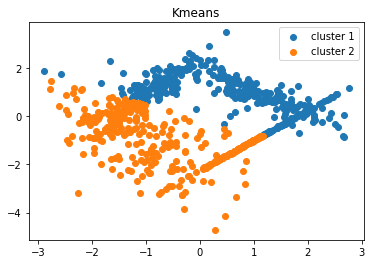

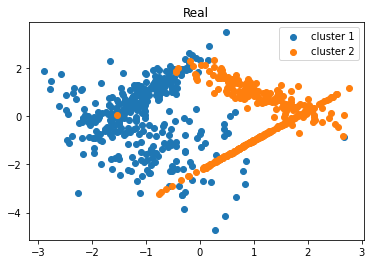

K-means :
 Purity =  0.3429
 Rand index =  0.5516


In [148]:
import collections
from sklearn.metrics.cluster import contingency_matrix


def purity(predict, y, k=2):
    p = 0
    for i in range(k):
        right_clustered = 0
        for j in range(len(predict)):
            if predict[j] == i and y[j] == i:
                right_clustered += 1
        p += right_clustered
    return p/ len(predict)


def rand_index(predict, y):
    tp_tn = 0
    for i in range(len(y)):
        for j in range(i+1):
            t_i, tj = predict[i], predict[j]
            if (t_i == tj and y[i] == y[j]) or (t_i != tj and y[i] != y[j]):
                tp_tn += 1
    return (tp_tn / ((len(y)*(len(y) - 1))/2))

    
clustered = None
for i in range(3):
    kmeans = Kmeans(X, 2)
    kmeans.init_centers()
    clustered_new = kmeans.cluster()
    if i == 0:
      clustered = clustered_new
    else:
      if round(purity(clustered_new, Y), 4) > round(purity(clustered, Y), 4):
        clustered = clustered_new
plt.scatter(X[clustered == 0, 0], X[clustered == 0, 1])
plt.scatter(X[clustered == 1, 0], X[clustered == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

print("K-means :")
print(" Purity = ", round(purity(clustered, Y), 4))
print(" Rand index = ", round(rand_index(clustered, Y), 4))

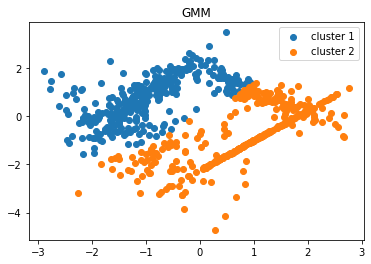

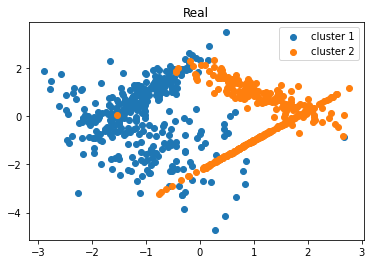

GMM :
Purity =  0.7914
Rand index =  0.6723


In [149]:
from scipy.stats import multivariate_normal
import matplotlib.colors as c
import math


class GMM():
    def __init__(self, k):
        self.k = k
        self.pi = [1/self.k for _ in range(self.k)]
    
    def fit(self, X, clustered):
        n = X.shape[0]
        d = X.shape[1]      
        new_X = np.array([np.array(X[clustered == 0]), np.array(X[clustered == 1])], dtype=object)
        mean = [np.mean(x, axis=0) for x in new_X]
        covariance = [np.cov(x.T.astype(float)) for x in new_X]
        first = True
        x = 0
        while True:
            r = np.zeros((len(X), self.k))
            for i in range(len(X)):
                for j in range(self.k):
                    r[i][j] = (self.pi[j] * multivariate_normal.pdf(X[i], 
                              mean=mean[j], cov=covariance[j]))/(sum([self.pi[k]*multivariate_normal.pdf(X[i], mean=mean[k],
                              cov=covariance[k]) for k in range(self.k)]))
            N = np.sum(r, axis=0)
            mean = np.dot(X.T, r) / N
            covariance = [np.zeros((len(X[0]), len(X[0]))) for _ in range(self.k)]
            for j in range(self.k):
                for i in range(len(X)):
                    X_tilda = np.reshape(X[i]- mean[:,j], (X.shape[1], 1))
                    covariance[j] += r[i][j] * np.matmul(X_tilda, X_tilda.T)
                covariance[j] /= N[j]
            self.pi = [N[j]/len(X) for j in range(self.k)]
            if first:
                ll = self.ll_calculation(X, r, mean, covariance)
                first = False
            else:
                oldll = ll
                ll = self.ll_calculation(X, r, mean, covariance)
                if math.fabs(ll - oldll) < 1e-1:
                    break
        return r

    def ll_calculation(self, X, r, mean, cov):
        sum = 0
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):
                sum += (r[i][j]*math.log(self.pi[j])) + (r[i][j]*multivariate_normal.logpdf(X[i], mean=mean[j], cov=cov[j]))
        return sum

    def cluster(self, r):
        y = np.zeros(X.shape[0])
        for i in range(len(r)):
            y[i] = (np.argmax(r[i]))
        return y

gmm = GMM(2)  
Q = gmm.fit(X, clustered)
y_gmm = gmm.cluster(Q)

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

print("GMM :")
print("Purity = ", round(purity(y_gmm, Y), 4))
print("Rand index = ", round(rand_index(y_gmm, Y), 4))

<div dir='rtl'>
با توجه به آزمایش های انجام شده عموما GMM نتایج بهتری نسبت به Kmeans دارد.
    <br>
    در اینجا پس از پایان GMM کلاسی را که احتمال بیشتری دارد را به عنوان کلاس آن نقطه انتخاب می‌کنیم.
</div>

<div dir='rtl'>
<h3>ب (۱۰ نمره)</h3>

با استفاده از دستورات زیر دیتاست جدید ایجاد کنید. سپس الگوریتم‌های 
Kmeans
و 
GMM
را روی آن‌ها اجرا کنید

در نهایت نتیجه‌ی خوشه‌بندی را بصری‌سازی کنید و نتایج بدست آمده را با هم مقایسه نمایید.


---

برای بصری‌سازی می‌توانید از کتابخانه‌های آماده استفاده کنید.
</div>

In [112]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

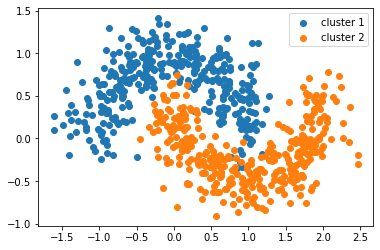

In [113]:
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

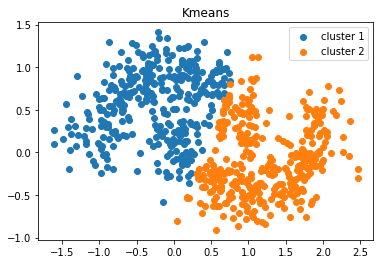

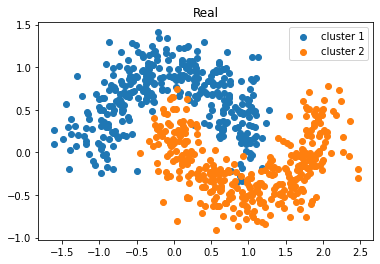

In [114]:
clustered = None
for i in range(3):
    kmeans = Kmeans(X, 2)
    kmeans.init_centers()
    clustered_new = kmeans.cluster()
    if i == 0:
      clustered = clustered_new
    else:
      if round(purity(clustered_new, Y), 4) > round(purity(clustered, Y), 4):
        clustered = clustered_new
plt.scatter(X[clustered == 0, 0], X[clustered == 0, 1])
plt.scatter(X[clustered == 1, 0], X[clustered == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

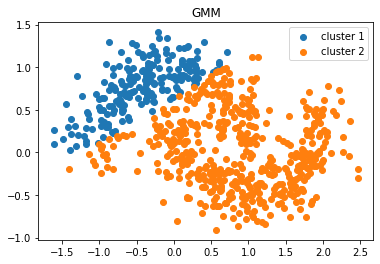

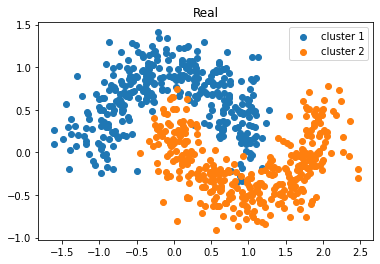

In [115]:
gmm = GMM(2)  
Q = gmm.fit(X, clustered)
y_gmm = gmm.cluster(Q)

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

<div dir='rtl'>
    برای این نوع داده نیز هم GMM به طور کلی عملکرد بهتری دارد. 
</div>

In [116]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

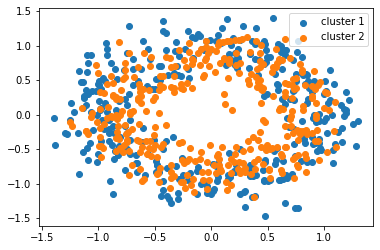

In [117]:
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

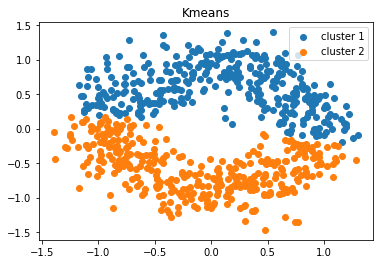

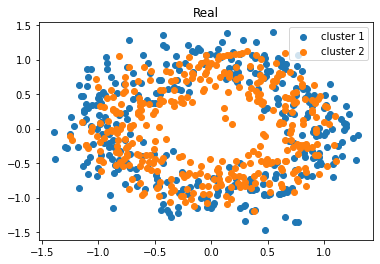

In [118]:
clustered = None
for i in range(3):
    kmeans = Kmeans(X, 2)
    kmeans.init_centers()
    clustered_new = kmeans.cluster()
    if i == 0:
      clustered = clustered_new
    else:
      if round(purity(clustered_new, Y), 4) > round(purity(clustered, Y), 4):
        clustered = clustered_new
plt.scatter(X[clustered == 0, 0], X[clustered == 0, 1])
plt.scatter(X[clustered == 1, 0], X[clustered == 1, 1])
plt.title("Kmeans")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()


plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

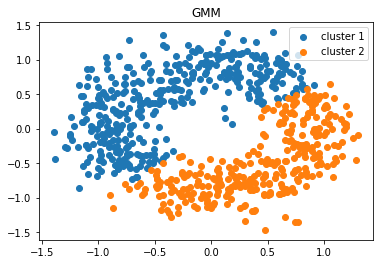

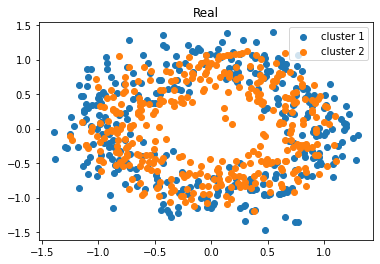

In [119]:
gmm = GMM(2)  
Q = gmm.fit(X, clustered)
y_gmm = gmm.cluster(Q)

plt.scatter(X[y_gmm == 0, 0], X[y_gmm == 0, 1])
plt.scatter(X[y_gmm == 1, 0], X[y_gmm == 1, 1])
plt.title("GMM")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1])
plt.title("Real")
plt.legend(['cluster 1', 'cluster 2'])
plt.show()

<div dir='rtl'>
    برای این نوع داده چون کلاستر ها جدا از هم نیستند و در هم ادغامند تقریبا میانگین هر دو کلاستر یکی است و جداسازی این داده‌ها توسط هیچ یک از دو روش به خوبی انجام نمی‌شود. در این نوع داده‌ها هر دو روش تقریبا نتیجه یکسانی را دارند. 
</div>